100%|██████████| 169001437/169001437 [00:03<00:00, 49403294.04it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


model.safetensors:   0%|          | 0.00/50.3M [00:00<?, ?B/s]

Epoch [1/50], Loss: 3.8581, Accuracy: 17.42%
Validation Accuracy after Epoch [1/50]: 51.45%
Epoch [2/50], Loss: 2.2037, Accuracy: 46.80%
Validation Accuracy after Epoch [2/50]: 70.99%
Epoch [3/50], Loss: 1.6919, Accuracy: 56.12%
Validation Accuracy after Epoch [3/50]: 75.93%
Epoch [4/50], Loss: 1.5071, Accuracy: 60.19%
Validation Accuracy after Epoch [4/50]: 78.11%
Epoch [5/50], Loss: 1.3814, Accuracy: 63.23%
Validation Accuracy after Epoch [5/50]: 79.09%
Epoch [6/50], Loss: 1.3126, Accuracy: 64.86%
Validation Accuracy after Epoch [6/50]: 80.69%
Epoch [7/50], Loss: 1.2522, Accuracy: 66.44%
Validation Accuracy after Epoch [7/50]: 81.13%
Epoch [8/50], Loss: 1.2126, Accuracy: 67.19%
Validation Accuracy after Epoch [8/50]: 81.91%
Epoch [9/50], Loss: 1.1697, Accuracy: 68.34%
Validation Accuracy after Epoch [9/50]: 81.90%
Epoch [10/50], Loss: 1.1198, Accuracy: 69.68%
Model saved at epoch 10
Validation Accuracy after Epoch [10/50]: 81.64%
Epoch [11/50], Loss: 1.1032, Accuracy: 69.86%
Validati

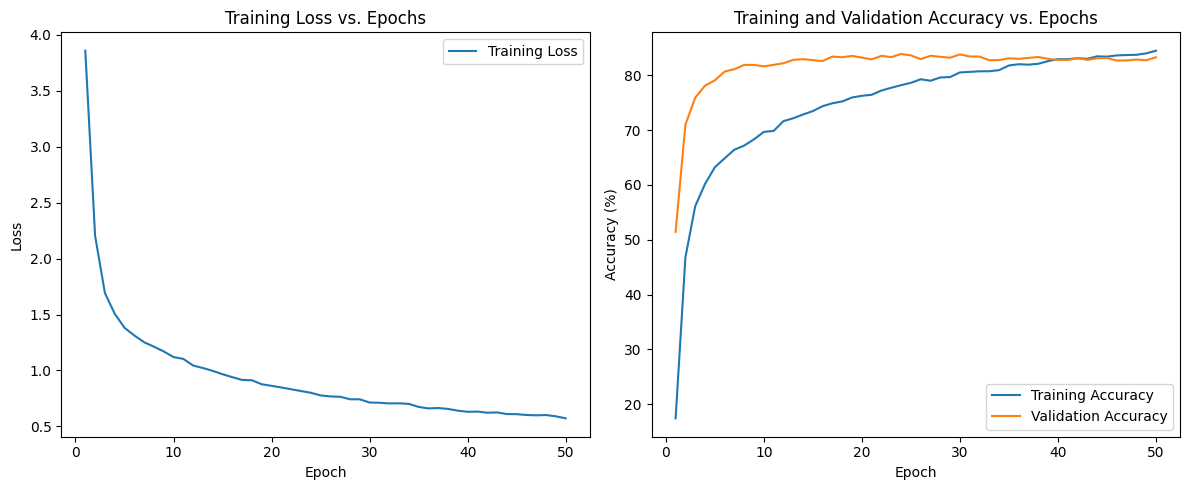

In [1]:
import torch
import timm
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from timm.data import create_dataset
from timm.data.transforms_factory import create_transform

# Load CIFAR-100 dataset
train_dataset = create_dataset('torch/cifar100', root='./data', download=True, split='train')
test_dataset = create_dataset('torch/cifar100', root='./data', download=True, split='validation')

# Define transformations and data loaders
transform_train = create_transform(input_size=224, is_training=True)
transform_val = create_transform(input_size=224, is_training=False)
train_dataset.transform = transform_train
test_dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model, define loss function, optimizer
model = timm.create_model('efficientvit_m5.r224_in1k', pretrained=True, num_classes=100)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Training settings
num_epochs = 50
save_interval = 10
train_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item() * images.size(0)

        # Calculate accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Save the model every 10 epochs
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy after Epoch [{epoch + 1}/{num_epochs}]: {val_accuracy:.2f}%")

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

# Plot Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()
